# Requirements

Install dependencies

In [1]:
from IPython.display import clear_output
import os
!{os.sys.executable} -m pip install opentrons cherrypy typing-extensions requests --upgrade
clear_output()
!{os.sys.executable} -m pip install -i https://test.pypi.org/simple/ covid19-system9 --upgrade
clear_output()
!{os.sys.executable} -m pip install ezdxf
clear_output()

Check package version

In [2]:
import system9
print(system9.__version__)

0.2.2


Import packages

In [3]:
from system9.a.copan_48 import StaggeredCopan48Specs
import json
import logging
logging.getLogger().setLevel(logging.WARNING)
import matplotlib
from matplotlib import pyplot as plt, patches
from matplotlib.collections import PatchCollection
import numpy as np
from typing import Tuple
import ezdxf
from ezdxf.addons import r12writer
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend
from itertools import chain
import tkinter as tk
import tkinter.filedialog
import copy
clear_output()

# Definitions

Labware definition

In [4]:
lab_def = StaggeredCopan48Specs()

Import original dxf file

In [5]:
dxf_fname = None
dxf = None
while dxf is None:
    root = tk.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    try:
        dxf_fname = tkinter.filedialog.askopenfilename()
        dxf = ezdxf.readfile(dxf_fname)
    except OSError as e:
        pass
    finally:
        root.destroy()

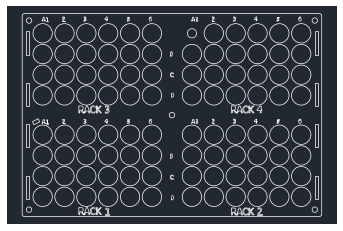

In [6]:
def plt_dxf(doc, ax=None):
    ctx = RenderContext(doc)
    out = MatplotlibBackend(plt.gca() if ax is None else ax)
    Frontend(ctx, out).draw_layout(doc.modelspace(), finalize=True)

plt_dxf(dxf)

Get coordinates of top-right corner

In [7]:
dxf_mod = ezdxf.readfile(dxf_fname)
msp = dxf_mod.modelspace()

frame = list(msp.query('POLYLINE'))[4]
tr_corner = min(p[0] for p in frame.points()), min(p[1] for p in frame.points())

Remove tube holes and labels

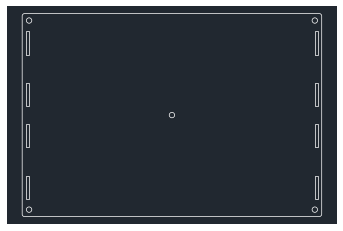

In [8]:
dxf_mod = ezdxf.readfile(dxf_fname)
msp = dxf_mod.modelspace()

for x in chain(
    filter(lambda x: (lambda w: w[0][0] - w[1][0])(list(x.vertices((0, 180)))) > 7.9, msp.query('CIRCLE')),
    msp.query('LINE'),
    msp.query('SPLINE'),
    (x for i, x in enumerate(msp.query('POLYLINE')) if i not in (0, 1, 2, 3, 4, 5, 6, 7, 8)),
    ):
    msp.delete_entity(x)

plt_dxf(dxf_mod)

Add new tube holes

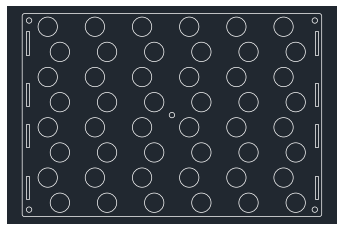

In [9]:
for k, well in lab_def.wells.items():
    msp.add_circle((well["x"] + tr_corner[0], well["y"] + tr_corner[1]), radius=lab_def._d/2)

plt_dxf(dxf_mod)

# Save

Save DXF

In [10]:
root = tk.Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
try:
    dxf_mod.saveas(tkinter.filedialog.asksaveasfilename(defaultextension='.dxf', filetypes=[('DXF', '*.dxf')]))
finally:
    root.destroy()

Save JSON

In [11]:
root = tk.Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
try:
    with open(tkinter.filedialog.asksaveasfilename(defaultextension='.json', filetypes=[('JSON', '*.json')]), "w") as f:
        json.dump(lab_def.toJSON(), f, indent=2)
finally:
    root.destroy()